In [1]:
import anndata as ad
import networkx as nx
import numpy as np
import pandas as pd
import scglue
import seaborn as sns
from IPython import display
from matplotlib import rcParams
from networkx.algorithms.bipartite import biadjacency_matrix
from networkx.drawing.nx_agraph import graphviz_layout
import pygraphviz as pgv

In [2]:
scglue.plot.set_publication_params()
rcParams['figure.figsize'] = (15, 15)

In [3]:
rna = ad.read_h5ad("rna-emb_m.h5ad")
atac = ad.read_h5ad("atac-emb_m.h5ad")
guidance_hvf = nx.read_graphml("guidance-hvf_m.graphml.gz")

In [4]:
rna.var["name"] = rna.var_names
atac.var["name"] = atac.var_names

In [5]:
genes = rna.var.query("highly_variable").index
peaks = atac.var.query("highly_variable").index

In [6]:
features = pd.Index(np.concatenate([rna.var_names, atac.var_names]))
feature_embeddings = np.concatenate([rna.varm["X_glue"], atac.varm["X_glue"]])

In [7]:
skeleton = guidance_hvf.edge_subgraph(
    e for e, attr in dict(guidance_hvf.edges).items()
    if attr["type"] == "fwd"
).copy()

In [8]:
reginf = scglue.genomics.regulatory_inference(
    features, feature_embeddings,
    skeleton=skeleton, random_state=0
)

regulatory_inference:   0%|          | 0/11541 [00:00<?, ?it/s]

In [9]:
gene2peak = reginf.edge_subgraph(
    e for e, attr in dict(reginf.edges).items()
    if attr["qval"] < 0.05
)

In [11]:
scglue.genomics.Bed(atac.var).write_bed("peaks_m.bed", ncols=3)
scglue.genomics.write_links(
    gene2peak,
    scglue.genomics.Bed(rna.var).strand_specific_start_site(),
    scglue.genomics.Bed(atac.var),
    "gene2peak_m.links", keep_attrs=["score", "pval", "qval"]
)

In [6]:
motif_bed = scglue.genomics.read_bed("JASPAR2022-hg38.bed.gz")
motif_bed.head()

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
0,GL000008.2,38,48,SOX2,.,.,.,.,.,.,.,.
1,GL000008.2,327,344,ZNF684,.,.,.,.,.,.,.,.
2,GL000008.2,332,344,TEAD1,.,.,.,.,.,.,.,.
3,GL000008.2,332,344,TEAD2,.,.,.,.,.,.,.,.
4,GL000008.2,672,689,ZNF684,.,.,.,.,.,.,.,.


In [7]:
tfs = pd.Index(motif_bed["name"])

In [13]:
tfs = pd.Index(motif_bed["name"]).intersection(rna.var_names)
tfs.size

634

In [14]:
rna.var['genes'] = rna.var_names
rna.obs['cells'] = rna.obs_names

In [15]:
rna[:, np.union1d(genes, tfs)].write_loom("rna_m.loom")
np.savetxt("tfs_m.txt", tfs, fmt="%s")

The loom file will lack these fields:
{'PCs', 'tSNE', 'X_pca', 'PCA', 'X_glue', 'UMAP', 'X_umap', 'Aligned'}
Use write_obsm_varm=True to export multi-dimensional annotations


In [16]:
!pyscenic grn rna_m.loom tfs_m.txt \
    -o draft_grn_m.csv --seed 0 --num_workers 20 \
    --cell_id_attribute cells --gene_attribute genes


2022-10-25 15:18:29,587 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-10-25 15:18:30,282 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork fro

In [17]:
peak_bed = scglue.genomics.Bed(atac.var.loc[peaks])
peak2tf = scglue.genomics.window_graph(peak_bed, motif_bed, 0, right_sorted=True)
peak2tf = peak2tf.edge_subgraph(e for e in peak2tf.edges if e[1] in tfs)

window_graph:   0%|          | 0/11451 [00:00<?, ?it/s]

In [18]:
rna.var['chromStart'] = rna.var['chromStart'].values.astype(int)
rna.var['chromEnd']   = rna.var['chromEnd'].values.astype(int)
atac.var['chromStart'] = atac.var['chromStart'].values.astype(int)
atac.var['chromEnd']  = atac.var['chromEnd'].values.astype(int)

gene2tf_rank_glue = scglue.genomics.cis_regulatory_ranking(
    gene2peak, peak2tf, genes, peaks, tfs,
    region_lens=atac.var.loc[peaks, "chromEnd"] - atac.var.loc[peaks, "chromStart"],
    random_state=0
)
gene2tf_rank_glue.iloc[:5, :5]

/home/people/rohit/miniconda3/envs/mypython3/lib/python3.8/site-packages/scglue/genomics.py:746: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  gene2region = biadjacency_matrix(gene2region, genes, regions, dtype=np.int16, weight=None)
/home/people/rohit/miniconda3/envs/mypython3/lib/python3.8/site-packages/scglue/genomics.py:747: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  region2tf = biadjacency_matrix(region2tf, regions, tfs, dtype=np.int16, weight=None)


cis_reg_ranking.sampling:   0%|          | 0/1826 [00:00<?, ?it/s]

cis_reg_ranking.mapping:   0%|          | 0/1000 [00:00<?, ?it/s]

,SOX2,ZNF684,TEAD1,TEAD2,NKX2-2
HES4,988.5,1136.0,1075.5,1065.0,1016.5
ISG15,988.5,1136.0,1075.5,1065.0,1016.5
TNFRSF18,988.5,1136.0,1075.5,1065.0,1016.5
TNFRSF4,988.5,31.5,1075.5,1065.0,1016.5
ANKRD65,988.5,208.5,1075.5,1065.0,1016.5


In [19]:
flank_bed = scglue.genomics.Bed(rna.var.loc[genes]).strand_specific_start_site().expand(500, 500)
flank2tf = scglue.genomics.window_graph(flank_bed, motif_bed, 0, right_sorted=True)

window_graph:   0%|          | 0/1826 [00:00<?, ?it/s]

In [20]:
gene2flank = nx.Graph([(g, g) for g in genes])
gene2tf_rank_supp = scglue.genomics.cis_regulatory_ranking(
    gene2flank, flank2tf, genes, genes, tfs,
    n_samples=0
)
gene2tf_rank_supp.iloc[:5, :5]

/home/people/rohit/miniconda3/envs/mypython3/lib/python3.8/site-packages/scglue/genomics.py:746: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  gene2region = biadjacency_matrix(gene2region, genes, regions, dtype=np.int16, weight=None)
/home/people/rohit/miniconda3/envs/mypython3/lib/python3.8/site-packages/scglue/genomics.py:747: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  region2tf = biadjacency_matrix(region2tf, regions, tfs, dtype=np.int16, weight=None)


,SOX2,ZNF684,TEAD1,TEAD2,NKX2-2
HES4,924.0,961.0,941.5,942.5,931.5
ISG15,924.0,961.0,941.5,942.5,931.5
TNFRSF18,924.0,961.0,941.5,942.5,931.5
TNFRSF4,924.0,961.0,941.5,942.5,931.5
ANKRD65,924.0,961.0,941.5,942.5,931.5


In [21]:
gene2tf_rank_glue.columns = gene2tf_rank_glue.columns + "_glue"
gene2tf_rank_supp.columns = gene2tf_rank_supp.columns + "_supp"

In [25]:
scglue.genomics.write_scenic_feather(gene2tf_rank_glue, "glue_m.genes_vs_tracks.rankings.feather")
scglue.genomics.write_scenic_feather(gene2tf_rank_supp, "supp_m.genes_vs_tracks.rankings.feather")

In [26]:
pd.concat([
    pd.DataFrame({
        "#motif_id": tfs + "_glue",
        "gene_name": tfs
    }),
    pd.DataFrame({
        "#motif_id": tfs + "_supp",
        "gene_name": tfs
    })
]).assign(
    motif_similarity_qvalue=0.0,
    orthologous_identity=1.0,
    description="placeholder"
).to_csv("ctx_annotation_m.tsv", sep="\t", index=False)

In [ ]:
!pyscenic ctx draft_grn_m.csv \
    glue_m.genes_vs_tracks.rankings.feather \
    supp_m.genes_vs_tracks.rankings.feather \
    --annotations_fname ctx_annotation_m.tsv \
    --expression_mtx_fname rna_m.loom \
    --output pruned_grn_myeloid_threshold100.csv \
    --rank_threshold 100 \
    --min_genes 10 \
    --cell_id_attribute cells \
    --gene_attribute genes 2> ~/pyscenic_ctx_error_m

In [3]:
grn = scglue.genomics.read_ctx_grn("pruned_grn_myeloid_threshold100.csv")

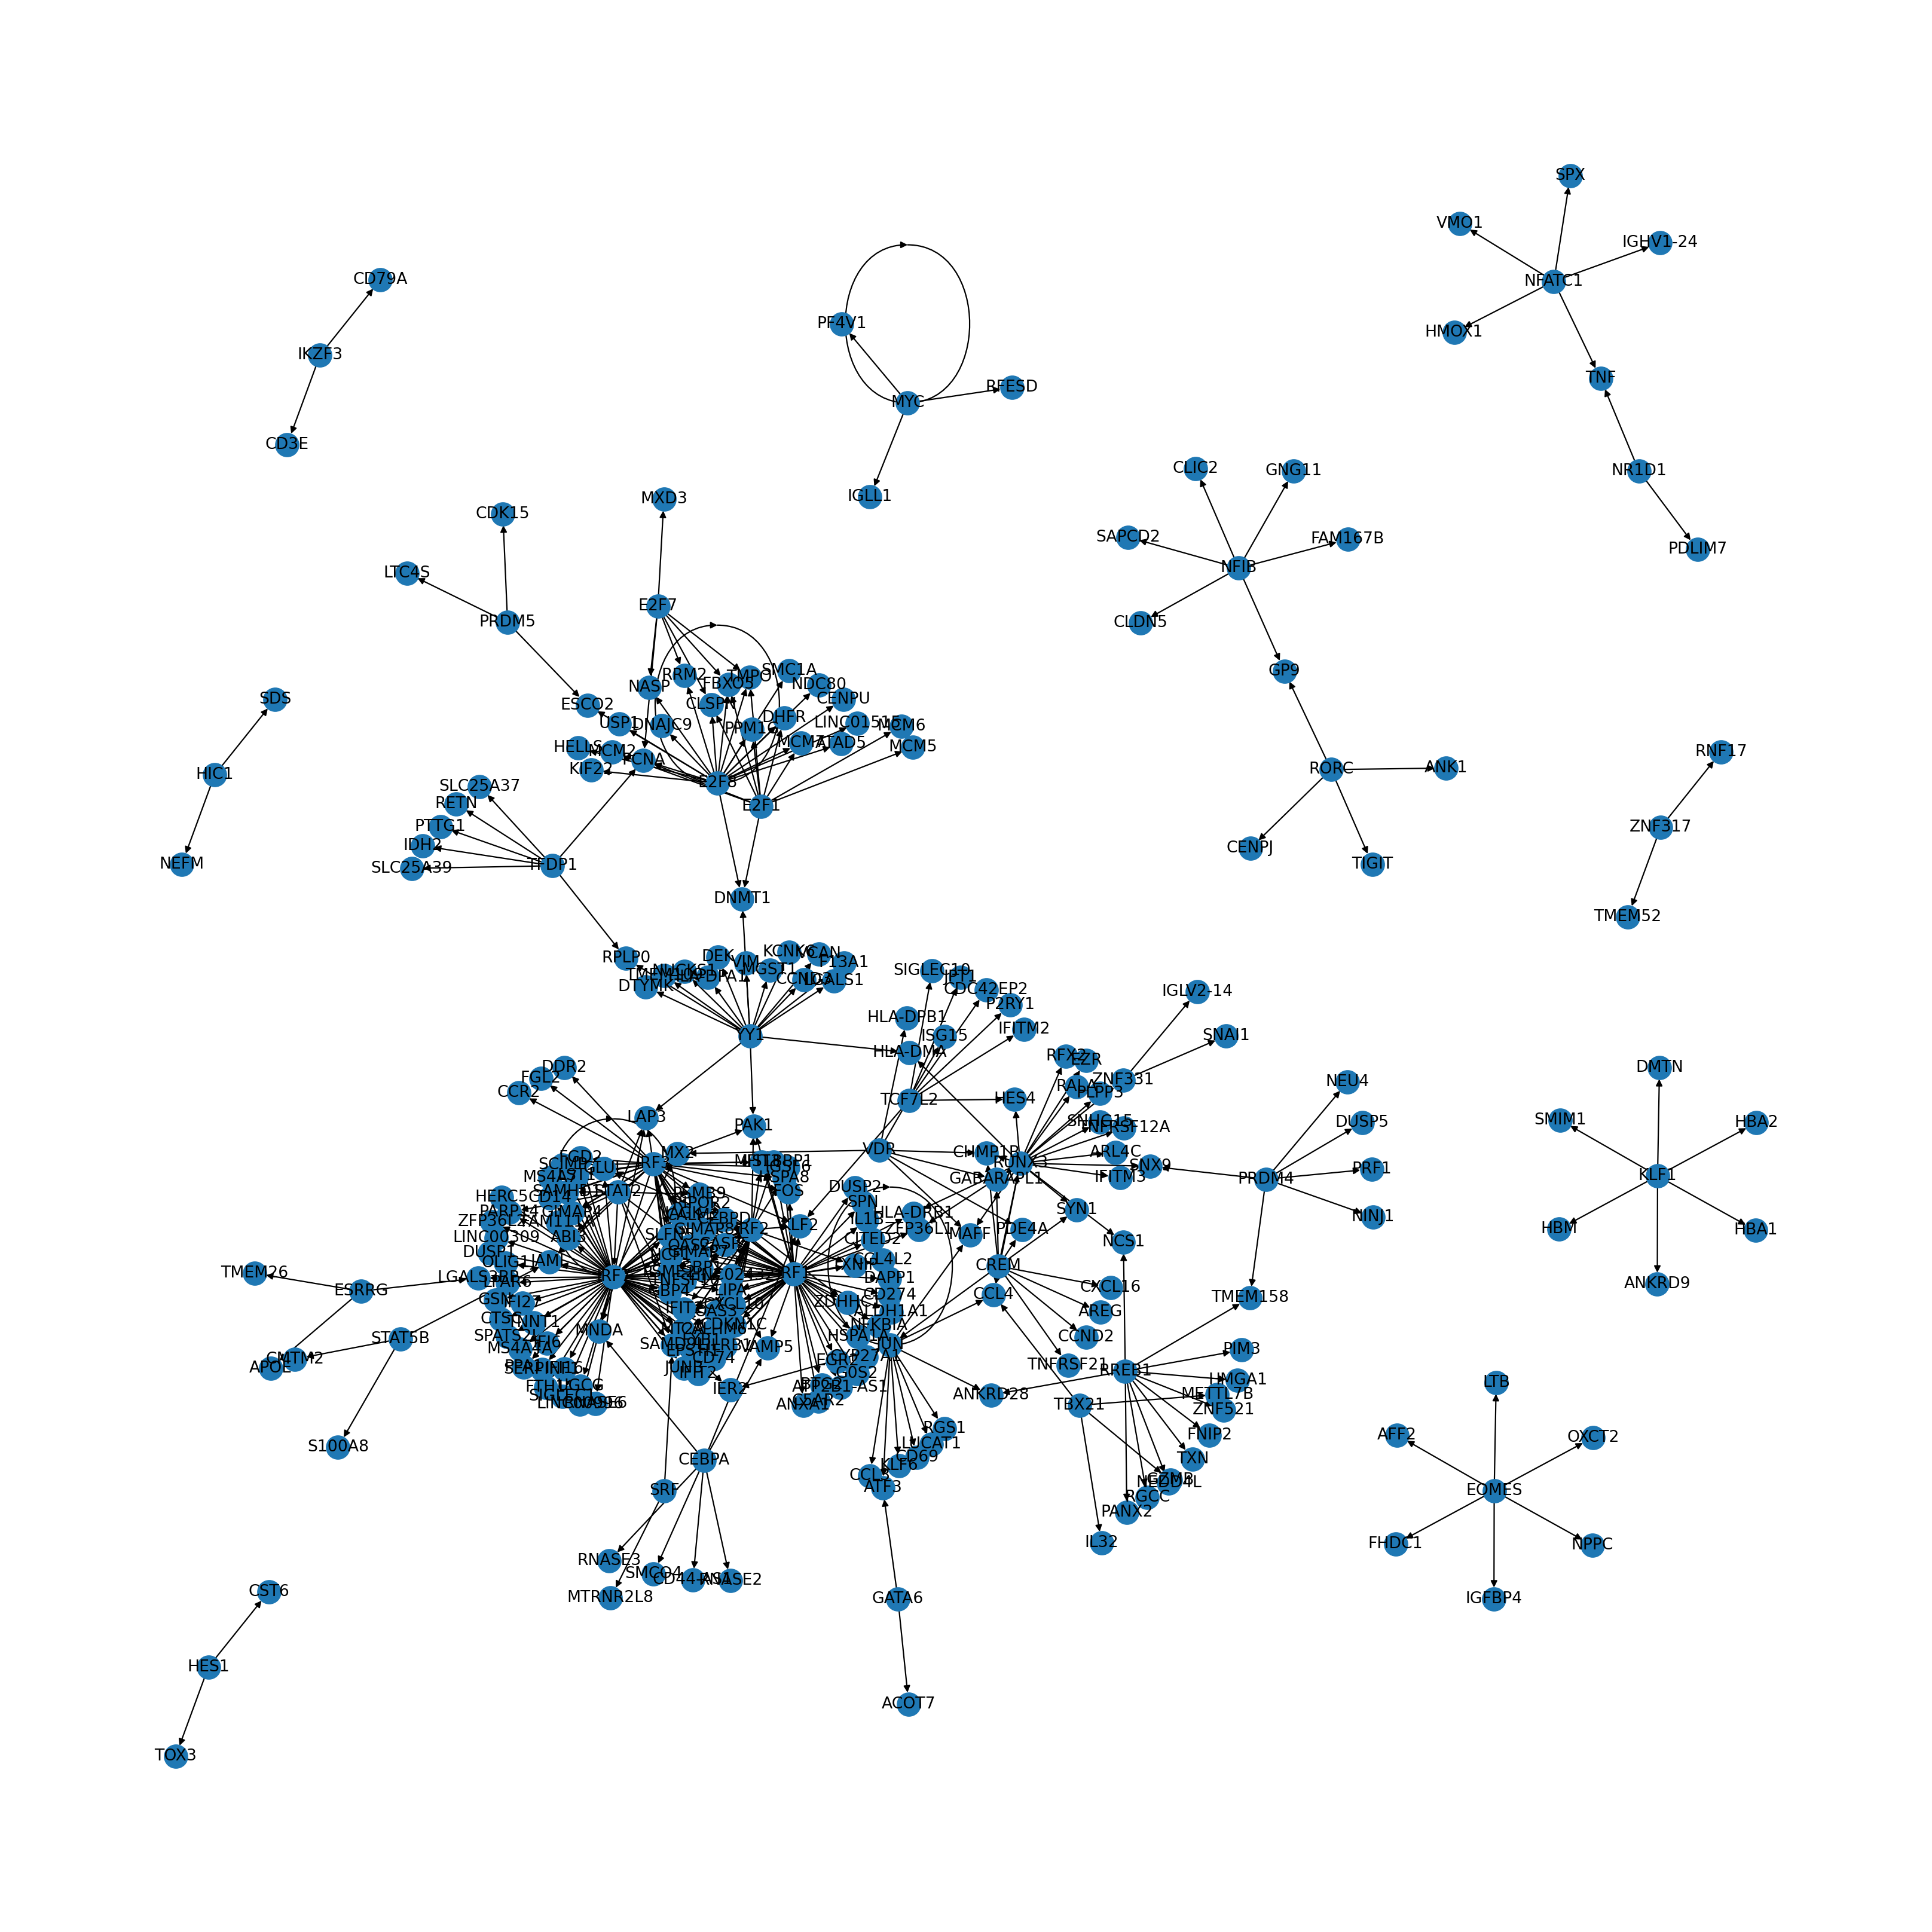

In [36]:
rcParams['figure.figsize'] = (20, 20)
nx.draw(grn, graphviz_layout(grn), with_labels=True)

In [12]:
mvsc_file = open("goi_mvsc.txt", "r")
mvsc_lines = mvsc_file.readlines()
goi_mvsc = [gene.strip() for gene in mvsc_lines]
mvsc_file.close()

In [15]:
import math
pre_weight = list(nx.get_edge_attributes(grn, 'weight').values())
weights = [round(math.log10(i),1) for i in pre_weight]

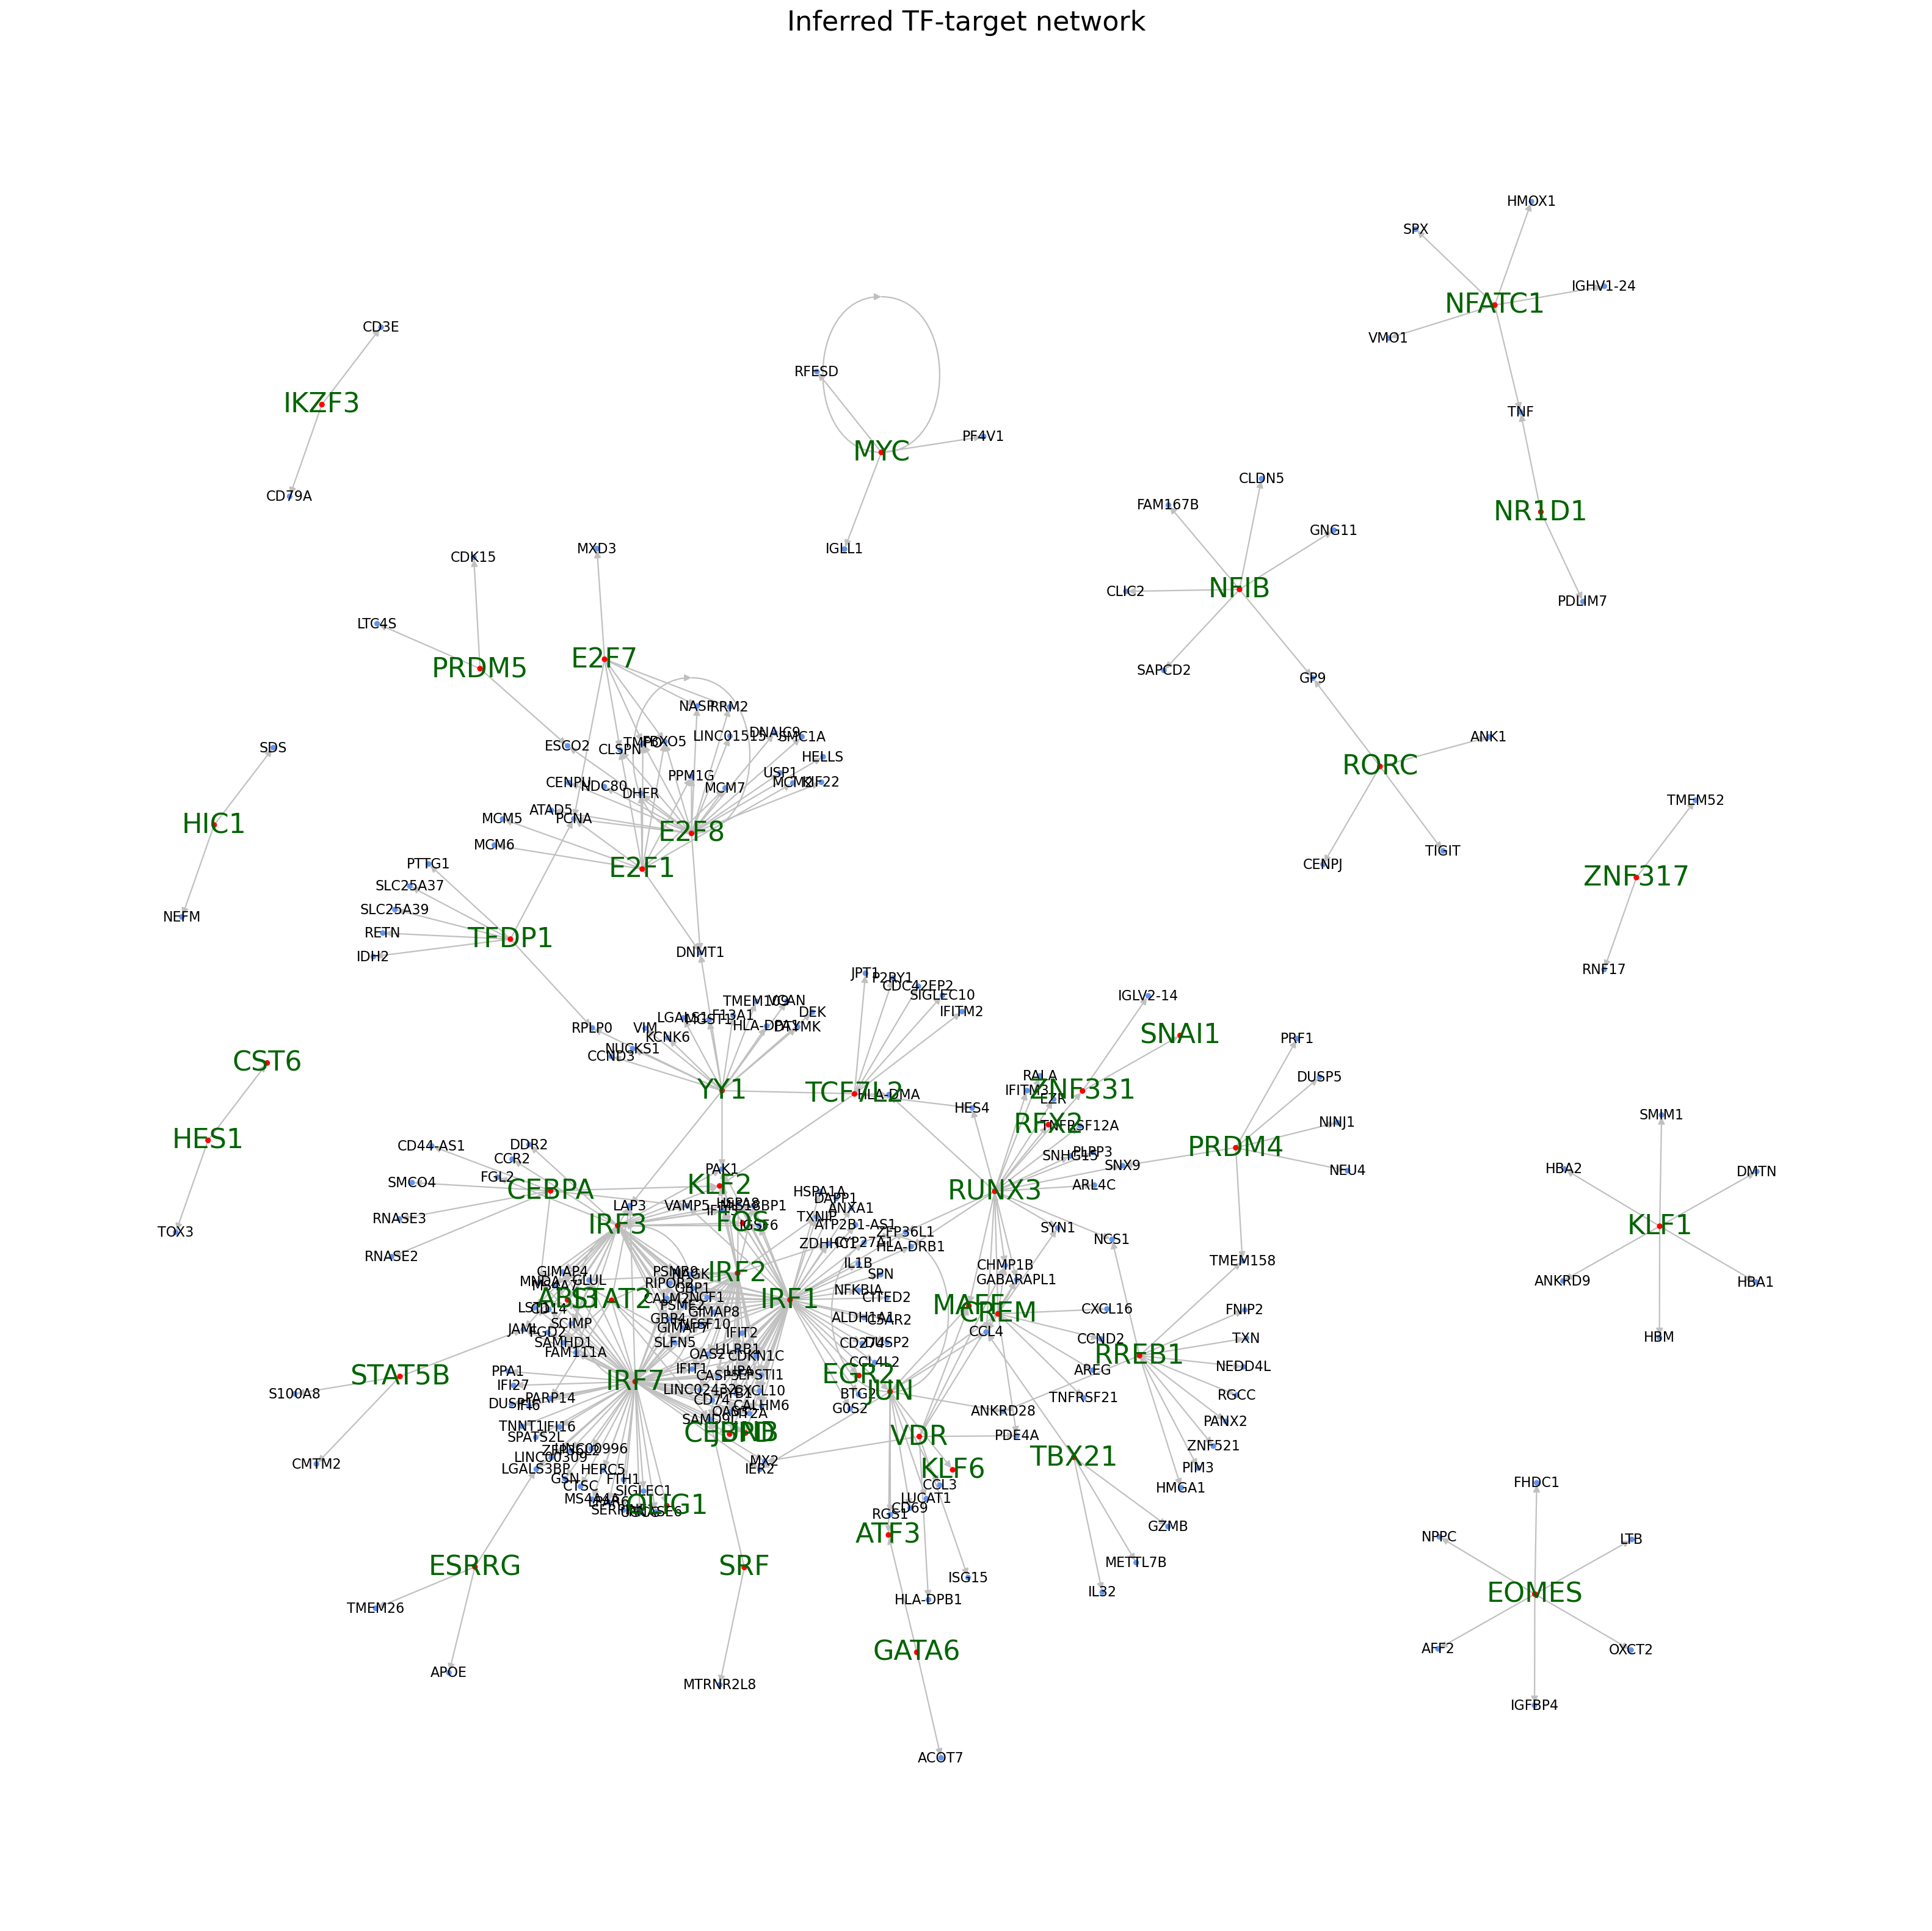

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,20))
ax = plt.subplot(111)
ax.set_title('Inferred TF-target network', fontsize=20)
# generate layout
pos = graphviz_layout(grn)

# generate positions for labels
nodes_small_font = []
nodes_large_font = []
net_start = []
for i in grn.nodes:
    if i not in tfs:
        nodes_small_font.append(i)
    elif i in tfs:
        nodes_large_font.append(i)
    elif i in goi_mvsc:
        net_start.append(i)
color = []
for  i in grn.nodes:
    if i in tfs:
        color.append('red')
    else:
        color.append('cornflowerblue')
        
pos_small = {k: v for k, v in pos.items() if k not in tfs}
pos_large = {k: v for k, v in pos.items() if k in tfs}
network_start= {k: v for k, v in pos.items() if k in goi_mvsc }

nx.draw(grn, pos, node_size=10, node_color=color, edge_color='silver') #, width=weights
nx.draw_networkx_labels(grn.subgraph(nodes_small_font), pos_small, font_size=10, font_color='k')
nx.draw_networkx_labels(grn.subgraph(nodes_large_font), pos_large, font_size=20, font_color='darkgreen')
nx.draw_networkx_labels(grn.subgraph(net_start), network_start, font_size=20, font_color='crimson')

plt.tight_layout()
plt.savefig("Graph_new_myeloid.svg", format="SVG")
plt.show()